# Fine tuning text embedding models using sentence_transformers

If you're building an LLM application your system will likely include a semantic cache to store previous LLM responses and return those cached answers instead of hitting your LLM again to generate the same answer as before.

Semantic caching improves response time, cost, and user experience, but introduces a new measure of cache performance beyond hit rate - the notions of true and false cache hits.

Because semantic caches are not performing exact key-value cache lookups, but instead doing vector similarity search on text embeddings, we're not guaranteed that every cache hit will be a relevant result, or that every cache miss means our cache doesn't hold the answer we're looking for. This is why using the correct text embedding model is critical. Using a text embedding model specifically fine tuned to correctly match queries for your system can improve your overall cache performance.

This notebook uses the [sentence_transformers](https://sbert.net/) library to fine tune a text embedding model on a custom dataset.
The training method used is contrastive fine tuning, where two statements are assigned a label as either being similar {label=1.0} or dissimilar {label=0.0}.
Training then proceeds to minimize the cosine distance between similar statements, and maximize the cosine distance between dissimilar statements.

This contrastive loss function is well suited to semantic cache applications where we care about the metrics true positive, true negative, false positive, and false negative.

## Let's Begin!
<a href="https://colab.research.google.com/github/redis-developer/redis-ai-resources/blob/main/python-recipes/finetuning/00_text_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install  --quiet torch datasets sentence_transformers 'transformers[torch]' redisvl


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip


## Select our starting model and dataset to fine tune on
To perform finetuning you'll need a dataset that ideally is specific to your use case. For the type of training we'll be doing - contrastive fine tuning - you'll need to structure your dataset as a set of pairs of questions or statements and coresponding label indicating if they're similar or not.

An example of what this looks like is in `sample_dataset.csv`

| question_1 | question_2 | label |
|------------|------------|-------|
| What is AI? | What is artificial intelligence? | 1.0 |
| How to bake a cake? | How to make a sandwich? | 0.0 |
| Define machine learning. | Explain machine learning. | 1.0 |

In [31]:
# select the datasets to train and test on
# we've provided examples in the datasets directory of what these files should look like
train_data = 'sample_dataset.csv'
test_data = 'sample_testset.csv'

In [32]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import ContrastiveLoss
import copy

# load a model to train/finetune
model_name = 'sentence-transformers/all-mpnet-base-v2'
model = SentenceTransformer(model_name)

# make a copy of the weights before training if we want to compare how much they've changed
before_training = copy.deepcopy(model.state_dict())

# this loss requires pairs of text and a floating point similarity score as a label
# we'll use 'hard labels' of 1.0 or 0.0 as that is shown to lead to the best separation
loss = ContrastiveLoss(model)

# load an example training dataset that works with our loss function:
train_dataset = load_dataset("csv", data_files=f"datasets/{train_data}", split='train')

## Define our training arguments

In [33]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers

args = SentenceTransformerTrainingArguments(
    # required parameters
    output_dir=f"models/mpnet-trained_on_{train_data}",
    # optional training parameters
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    fp16=False,  # set to False if your GPU can't handle FP16
    bf16=False,  # set to True if your GPU supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses using "in-batch negatives" benefit from no duplicates
    # optional tracking/debugging parameters
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name=f"mpnet-base-{train_data}",  # used in Weights & Biases if `wandb` is installed
)

## Split your dataset to perform training validation
While our model is training both the training loss and validation loss will be recorded. These are printed to `stdout`, and also logged in
`models/mpnet-base-all/checkpoint-<step_num>/trainer_state.json`.

sentence_transformers uses the term 'evaluation' rather than 'validation'.

In [34]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction

# split the dataset into training and validation sets
train_dataset = train_dataset.train_test_split(train_size=0.8, seed=42)

validation_dataset = train_dataset['test']
train_dataset = train_dataset['train']

print('train', train_dataset)
print('validation', validation_dataset)

# initialize the evaluator
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=validation_dataset["question_1"],
    sentences2=validation_dataset["question_2"],
    scores=validation_dataset["label"],
    main_similarity=SimilarityFunction.COSINE,
    name=f"{train_data}-dev",
)

train Dataset({
    features: ['question_1', 'question_2', 'label'],
    num_rows: 41
})
validation Dataset({
    features: ['question_1', 'question_2', 'label'],
    num_rows: 11
})


## Train our model
This cell performs the full training for the number of epochs defined in our `SentenceTransformerTrainingArguments`, args. Losses are periodically printed out.

In [35]:
from sentence_transformers import SentenceTransformerTrainer

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    loss=loss,
    evaluator=dev_evaluator,
)
trainer.train()

# make a copy of the weights after training
after_training = copy.deepcopy(model.state_dict())

  0%|          | 0/3 [00:00<?, ?it/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

{'train_runtime': 4.2494, 'train_samples_per_second': 9.648, 'train_steps_per_second': 0.706, 'train_loss': 0.031828783452510834, 'epoch': 1.0}


## That's it!
That is all it takes to produce a finetuned model on your dataset. Every application is different and you'll want to know how well this model can do with your cache, and how much better it is now that you've tuned it. Here we compute some metrics to see the impact of fine tuning.
These will also help you choose the best cache hit similarity threshold for your app based on your criteria.

## Evaluate the trained model for use in a semantic cache
As the ultimate goal of this fine tuning is to improve performance for semantic caching we'll run an evaluation with our trained model to simulate a series of cache checks.

Here we can also evaluate on different datasets we haven't trained on. We've again provided a `sample_testset.csv` file to illustrate this, but you should replace this with data relevant to your app.

In [36]:
import numpy as np

def evaluate_model(model, test_dataset):
    q1_embeddings = [model.encode(pair['question_1']) for pair in test_dataset]
    q2_embeddings = [model.encode(pair['question_2']) for pair in test_dataset]
    labels = [pair['label'] for pair in test_dataset]

    # compute all the distances between all the vectors for quicker reference later
    distances = np.empty(shape=(len(q1_embeddings), len(q2_embeddings)), dtype=np.float32, order='C')
    for index_1, embedding_1 in enumerate(q1_embeddings):
        for index_2, embedding_2 in enumerate(q2_embeddings):
            # compute cosine distance between embeddings
            cosine_distance = 1 - np.dot(embedding_1, embedding_2) / (np.linalg.norm(embedding_1) * np.linalg.norm(embedding_2))
            distances[index_1, index_2] = cosine_distance

    # for our range of thresholds see which embeddings fall within our threshold and so would be returned from a cache
    metrics = {}
    thresholds = np.linspace(0.01, 0.6, 60)
    for threshold in thresholds:
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for index, label in enumerate(labels):
            # for question N find the most similar embedding, aka the one with the lowest distance
            distance_of_nearest = np.min(distances[index, :])
            index_of_nearest = np.argmin(distances[index, :])
            if distances[index, :][index_of_nearest] <= threshold: # if the distance is below our threshold it's a cache hit
                if label == 1: # check the label to see if it should have been a hit (label == 1) or if there shouldn't be a hit (label == 0)
                    if index_of_nearest == index: # verify that we hit the correct matched pair, and not some other question
                        TP += 1 # we correctly found a matching cache entry
                    else:
                        FP += 1 # we hit the cache, but returned a wrong result
                else:
                    FP += 1 # we hit the cache, but shouldn't have
            else: # it's a cache miss
                if label == 1: # check it should be a miss
                    FN += 1 # we failed to find a matching pair
                else:
                    TN += 1 # correctly did not match any other embeddings

        F1 = (2 * TP) / (2 * TP + FP + FN)
        accuracy = (TP + TN) / len(test_dataset)
        metrics[threshold] = {"TP": TP, "TN": TN, "FP": FP, "FN": FN, "accuracy": accuracy, 'F1': F1}

    return metrics

## Perform our final comparison on our models before and after fine tuning

In [37]:
# load the test dataset
test_dataset = load_dataset("csv", data_files=f"datasets/{test_data}", split='train')

In [38]:
model.load_state_dict(before_training)
metrics_before_training = evaluate_model(model, test_dataset)

model.load_state_dict(after_training)
metrics_after_training = evaluate_model(model, test_dataset)

## Visualize metrics
Since we're tracking multiple metrics - true & false positives & negatives, accuracy and F1 score - we want a way to quickly visually compare all of these.
We'll plot these metrics to see how they change after fine tuning, and also how we can influence them by selecting the best cosine similarity threshold for our semantic cache.

In [42]:
from matplotlib import pyplot as plt

def display_AUC(metrics_before, metrics_after):
    precision_before = [m['TP'] / (m['TP'] + m['FP']) if (m['TP'] + m['FP']) > 0 else 1 for m in metrics_before.values()]
    precision_after = [m['TP'] / (m['TP'] + m['FP']) if (m['TP'] + m['FP']) > 0 else 1 for m in metrics_after.values()]

    recall_before = [m['TP'] / (m['TP'] + m['FN']) if (m['TP'] + m['FN']) > 0 else 1 for m in metrics_before.values()]
    recall_after = [m['TP'] / (m['TP'] + m['FN']) if (m['TP'] + m['FN']) > 0 else 1 for m in metrics_after.values()]

    from sklearn.metrics import roc_auc_score
    y_true_before = []
    y_score_before = []
    y_true_after = []
    y_score_after = []

    for m in metrics_before.values():
        y_true_before.extend([1] * m['TP'] + [0] * m['FN'] + [0] * m['TN'] + [1] * m['FP'])
        y_score_before.extend([1] * m['TP'] + [1] * m['FN'] + [0] * m['TN'] + [0] * m['FP'])

    for m in metrics_after.values():
        y_true_after.extend([1] * m['TP'] + [0] * m['FN'] + [0] * m['TN'] + [1] * m['FP'])
        y_score_after.extend([1] * m['TP'] + [1] * m['FN'] + [0] * m['TN'] + [0] * m['FP'])

    auc_before = roc_auc_score(y_true_before, y_score_before)
    auc_after = roc_auc_score(y_true_after, y_score_after)

    plt.figure()
    plt.plot(recall_before, precision_before, scalex=False, scaley=False)
    plt.plot(recall_after, precision_after, scalex=False, scaley=False)
    plt.title(f'trained on {train_data}, test on {test_data}\n Precision Recall curves with finetuning')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0,1.1])
    plt.legend([f'before finetuning auc={auc_before :.4f}', f'after finetuning auc={auc_after :.4f}'])
    plt.show()


def display_accuracy(metrics_before, metrics_after):
    accuracy_before = [m['accuracy'] for m in metrics_before.values()]
    accuracy_after = [m['accuracy'] for m in metrics_after.values()]
    plt.figure()
    plt.plot(list(metrics_before.keys()), accuracy_before)
    plt.plot(list(metrics_after.keys()), accuracy_after)
    plt.title(f'trained on {train_data}, test on {test_data}\n Accuracy')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.ylim([0,1.1])
    plt.legend(['before finetuning', 'after finetuning'])
    plt.show()


def display_f1_score(metrics_before, metrics_after):
    F1_before = [m["F1"] for m in metrics_before.values()]
    F1_after = [m["F1"] for m in metrics_after.values()]

    plt.figure()
    plt.plot(list(metrics_before.keys()), F1_before)
    plt.plot(list(metrics_after.keys()), F1_after)
    plt.title(f'trained on {train_data}, test on {test_data}\n F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend(['before finetuning', 'after finetuning'])
    plt.show()


def display_metrics(metrics_before, metrics_after):
    colors = ['b','g','r','m']
    plt.figure()
    for val in zip(['TP', 'TN'], colors[:2]):
        plt.plot(list(metrics_before.keys()), [m[val[0]] for m in metrics_before.values()], color=val[1])
    for val in zip(['TP', 'TN'], colors[:2]):
        plt.plot(list(metrics_after.keys()), [m[val[0]] for m in metrics_after.values()], marker='.', color=val[1])

    plt.title(f'trained on {train_data}, test on {test_data}\n True Positives and Negatives -- higher is better')
    plt.xlabel('threshold')
    plt.ylabel('successes')
    plt.legend(['TP before', 'TN before', 'TP after', 'TN after'])

    plt.figure()
    for val in zip(['FP', 'FN'], colors[2:]):
        plt.plot(list(metrics_before.keys()), [m[val[0]] for m in metrics_before.values()], color=val[1])
    for val in zip(['FP', 'FN'], colors[2:]):
        plt.plot(list(metrics_after.keys()), [m[val[0]] for m in metrics_after.values()], marker='.', color=val[1])

    plt.title(f'trained on {train_data}, test on {test_data}\n False Positives and Negatives -- lower is better')
    plt.xlabel('threshold')
    plt.ylabel('errors')
    plt.legend(['FP before', 'FN before', 'FP after', 'FN after'])
    plt.figure()

    plt.show()


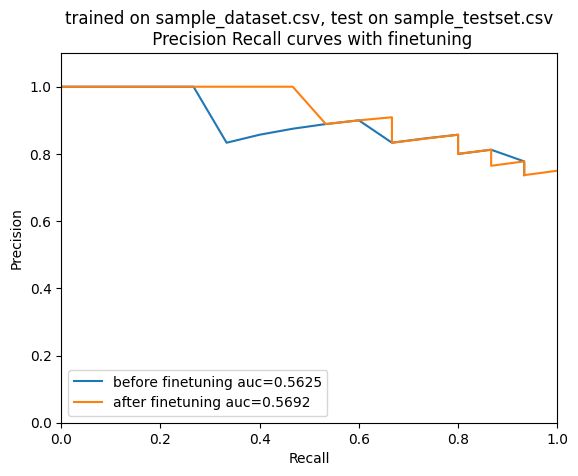

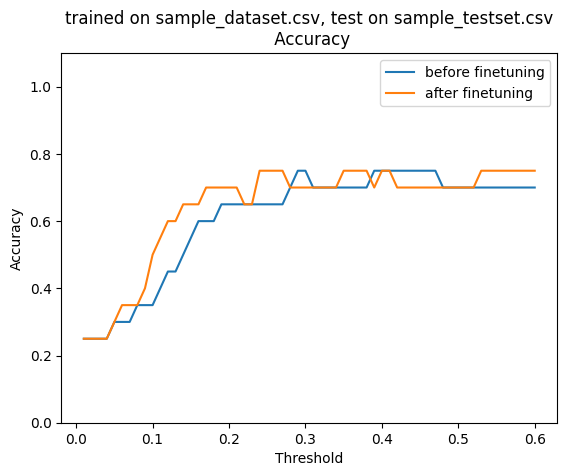

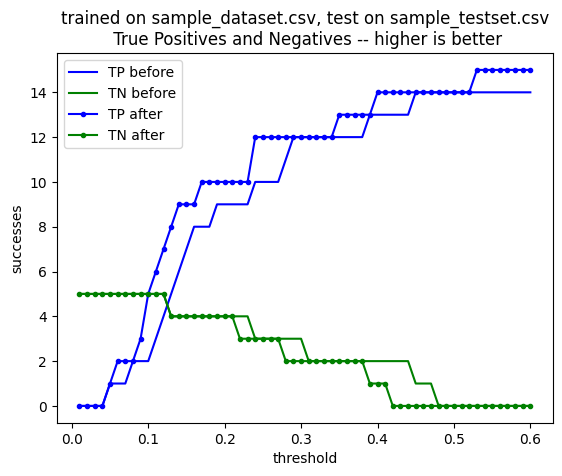

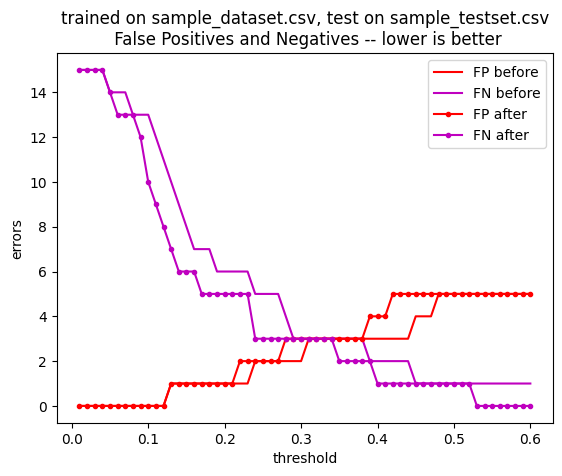

<Figure size 640x480 with 0 Axes>

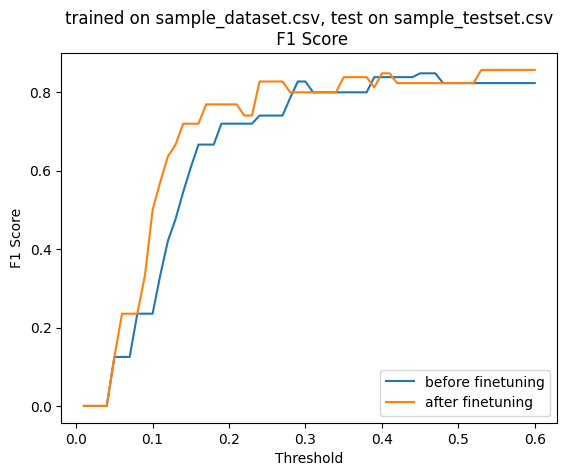

In [43]:
display_AUC(metrics_before_training, metrics_after_training)
display_accuracy(metrics_before_training, metrics_after_training)
display_metrics(metrics_before_training, metrics_after_training)
display_f1_score(metrics_before_training, metrics_after_training)

## Every use case is different
With semantic caching we always have to keep in mind there is a tradeoff between cache utilization, which improves response times and cuts LLM costs, and the risk of incorrect cache responses. You can control this tradeoff by selecting the cache similarity threshold that makes sense for your system.

If you want to drive down LLM calls and the occasional incorrect response from a cache hit is acceptable, then set a high threshold and return cached entries often.

Or if a false positive cache hit that results in a poor response to your users is something you want to minimize, then choose a small threshold and be confident that only highly similar results will be coming from your cache.
